## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/wfenton/.fastai/data/camvid/labels'),
 PosixPath('/home/wfenton/.fastai/data/camvid/images'),
 PosixPath('/home/wfenton/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/wfenton/.fastai/data/camvid/codes.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/wfenton/.fastai/data/camvid/images/0006R0_f01830.png'),
 PosixPath('/home/wfenton/.fastai/data/camvid/images/0006R0_f01650.png'),
 PosixPath('/home/wfenton/.fastai/data/camvid/images/0006R0_f02610.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/wfenton/.fastai/data/camvid/labels/0016E5_00540_P.png'),
 PosixPath('/home/wfenton/.fastai/data/camvid/labels/0016E5_00720_P.png'),
 PosixPath('/home/wfenton/.fastai/data/camvid/labels/0006R0_f02640_P.png')]

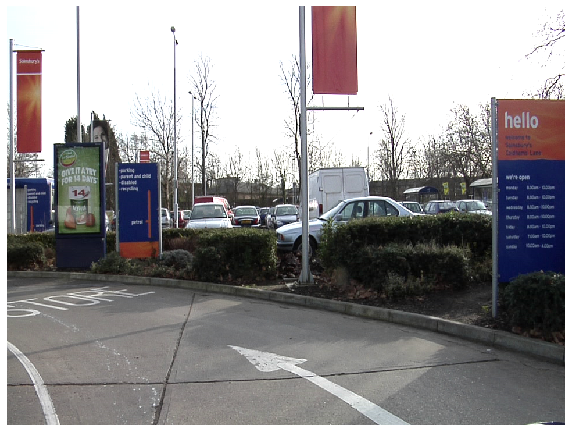

In [11]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(10,10))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

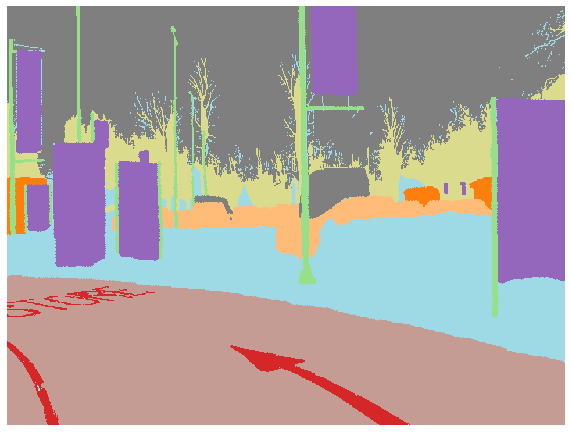

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [16]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=8
else:           
    bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7143MB of GPU RAM free


In [17]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [18]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

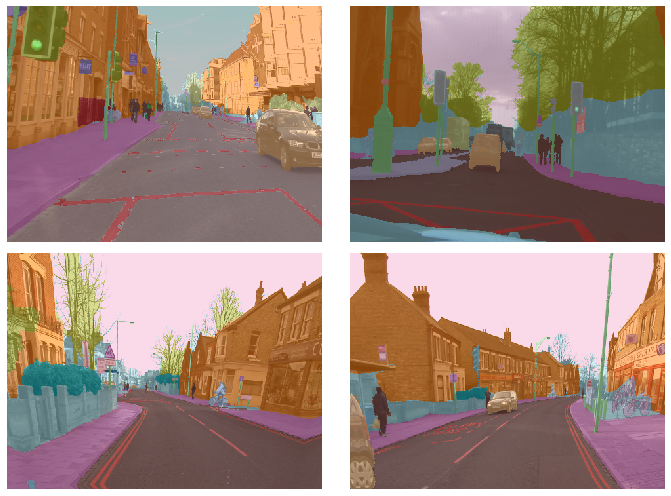

In [19]:
data.show_batch(2, figsize=(10,7))

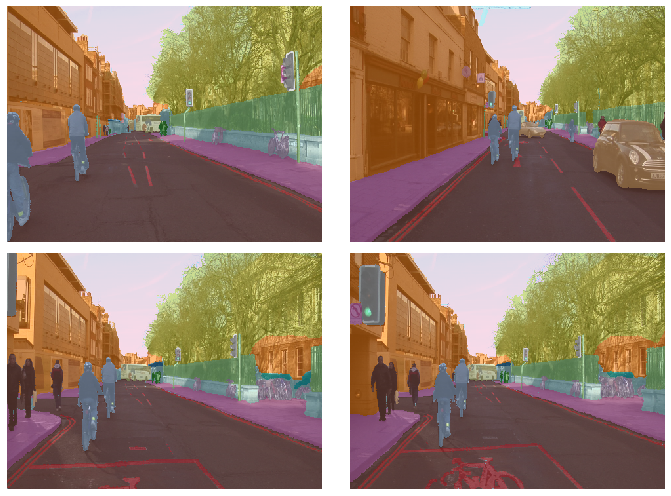

In [20]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [22]:
metrics=acc_camvid
# metrics=accuracy

In [23]:
wd=1e-2

In [24]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


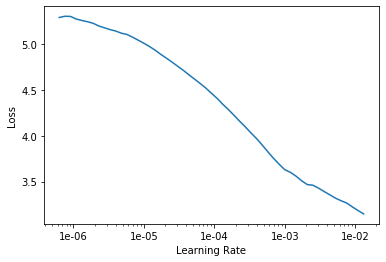

In [25]:
lr_find(learn)
learn.recorder.plot()

In [26]:
lr=3e-3

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.005922,0.865777,0.773565,00:51
1,0.738087,0.603808,0.854555,00:50
2,0.664012,0.640661,0.821959,00:50
3,0.662779,0.523152,0.859663,00:50
4,0.592770,0.510444,0.856194,00:50
5,0.574466,0.435438,0.877281,00:50
6,0.569605,0.480186,0.878078,00:50
7,0.528086,0.387890,0.899370,00:50
8,0.513115,0.385140,0.891241,00:50
9,0.422340,0.328755,0.904187,00:50


In [28]:
learn.save('stage-1')

In [29]:
learn.load('stage-1');

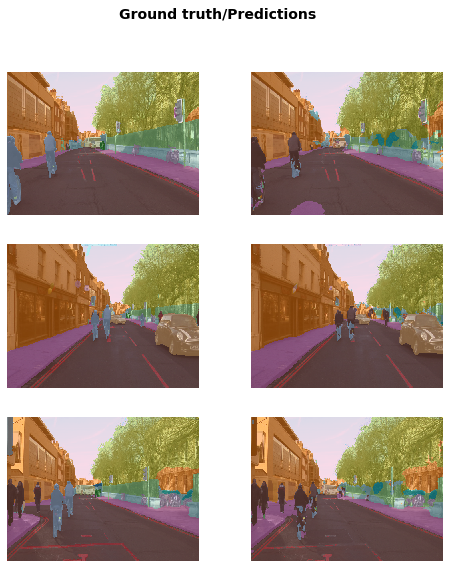

In [33]:
learn.show_results(rows=3, figsize=(8,9))

In [31]:
learn.unfreeze()

In [32]:
lrs = slice(lr/400,lr/4)

In [34]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.375282,0.325959,0.905286,00:52
1,0.371425,0.325464,0.904991,00:53
2,0.359060,0.306636,0.911315,00:52
3,0.353446,0.300050,0.917449,00:53
4,0.343598,0.300724,0.912343,00:53
5,0.352542,0.305341,0.916893,00:53
6,0.352324,0.307586,0.910655,00:53
7,0.342155,0.299100,0.914484,00:53
8,0.380854,0.353666,0.898631,00:53
9,0.412556,0.372687,0.902335,00:53


In [35]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [36]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 6447MB of GPU RAM free


In [37]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [38]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [39]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


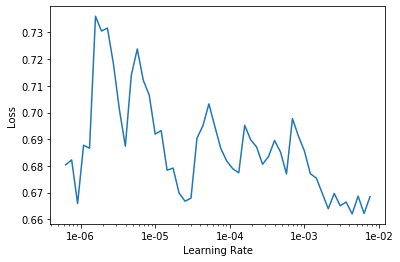

In [40]:
lr_find(learn)
learn.recorder.plot()

In [41]:
lr=1e-3

In [42]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.457813,0.374179,0.897109,03:18
1,0.454668,0.359739,0.899292,03:18
2,0.391009,0.325303,0.908180,03:18
3,0.420020,0.340577,0.904434,03:18
4,0.377710,0.371560,0.898422,03:18
5,0.375875,0.339561,0.907717,03:18
6,0.401006,0.318036,0.915209,03:18
7,0.398783,0.289595,0.919317,03:18
8,0.311142,0.317226,0.912191,03:18
9,0.265183,0.282225,0.921041,03:18


In [43]:
learn.save('stage-1-big')

In [44]:
learn.load('stage-1-big');

In [45]:
learn.unfreeze()

In [46]:
lrs = slice(1e-6,lr/10)

In [47]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.269419,0.280411,0.922479,03:29
1,0.256956,0.270505,0.923628,03:28
2,0.255468,0.267015,0.925958,03:28
3,0.232440,0.287848,0.920617,03:28
4,0.226430,0.272644,0.925533,03:28
5,0.232991,0.277540,0.923392,03:29
6,0.210987,0.265135,0.926408,03:28
7,0.223390,0.269199,0.926105,03:28
8,0.220054,0.271889,0.924667,03:28
9,0.200470,0.270799,0.924899,03:29


In [48]:
learn.save('stage-2-big')

In [49]:
learn.load('stage-2-big');

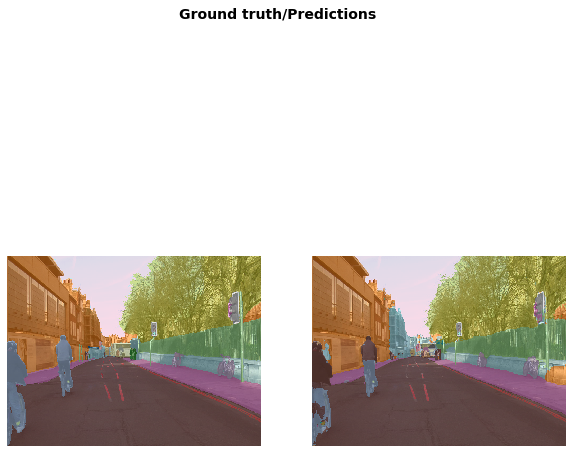

In [50]:
learn.show_results(rows=3, figsize=(10,10))